## H20 Interview Solution

### Great Britain Road Safety Dataset

These files provide detailed road safety data about the circumstances of personal injury road accidents in Great Britain from 1979, the types of vehicles involved and the consequential casualties. The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.

The dictionary of the colums are defined here:
https://www.dropbox.com/s/239wnyobolbt0im/Road-Accident-Safety-Data-Guide.xls?dl=0

This analysis is for the Data of 2019

- We are first going to take a look at the data and understand the data
- We will do some feature extraction
- We will look for class imbalances
- Build a classifier in h2o 
- Use open source h203 to do most of the work
- The Data engineering has been done using Pandas in the other notebook
- We will use the Pickle dataset from the other notebook to read the data and build the models
- The experimentation will be done on almost all H2o algorithms

Target Variable is "Did Police Attend"

        - 1 - Yes
        - 2 - No


In [ ]:
import h2o
from h2o.estimators.psvm import H2OSupportVectorMachineEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.automl import H2OAutoML
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score,classification_report

import pickle
import pandas as pd
import numpy as np

In [ ]:
h2o.init()

In [323]:
# road_safety_sel2.pkl
accident_df = pd.read_pickle('road_safety_sel2.pkl')

In [324]:
data = h2o.H2OFrame(accident_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
data.columns

In [ ]:
cols = ['Location_Easting_OSGR','Location_Northing_OSGR','Police_Force',  'Accident_Severity','Number_of_Vehicles','Number_of_Casualties', 'Day_of_Week', 'Local_Authority_(District)', 
    'Local_Authority_(Highway)','1st_Road_Class','1st_Road_Number','Road_Type', 'Speed_limit','Junction_Detail','2nd_Road_Number', 
    'Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions','Weather_Conditions', 
    'Road_Surface_Conditions','Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area','time_mins_scaled','Location_Easting_scaled','Location_Northing_scaled']

In [ ]:
data['Did_Police_Officer_Attend_Scene_of_Accident']

In [325]:
x = data.columns
y = "Did_Police_Officer_Attend_Scene_of_Accident"
x.remove(y)

In [326]:
data[y] = data[y].asfactor()
#test[y] = test[y].asfactor()

In [327]:
train, test, valid = data.split_frame(ratios=[.7, .15])



In [328]:
# Balance classes made the model worse
gbm_baseline=H2OGradientBoostingEstimator(score_tree_interval=10,
                                          ntrees=500,
                                          sample_rate=0.8,
                                          col_sample_rate=0.8,
                                          seed=1234,
                                          stopping_rounds=5,
                                          stopping_metric="AUCPR",
                                          stopping_tolerance=0.001,
                                          model_id="gbm_baseline_sd.hex")

In [329]:
gbm_baseline.train(x=cols, y=y, training_frame=train,
                   validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [330]:
y_gbm_predict=gbm_baseline.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [331]:
print(classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_gbm_predict["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.90      0.70      0.78     17923
           2       0.32      0.64      0.43      3998

    accuracy                           0.69     21921
   macro avg       0.61      0.67      0.61     21921
weighted avg       0.79      0.69      0.72     21921



In [332]:
gbm_baseline.auc(valid=True)

0.7439370410697984

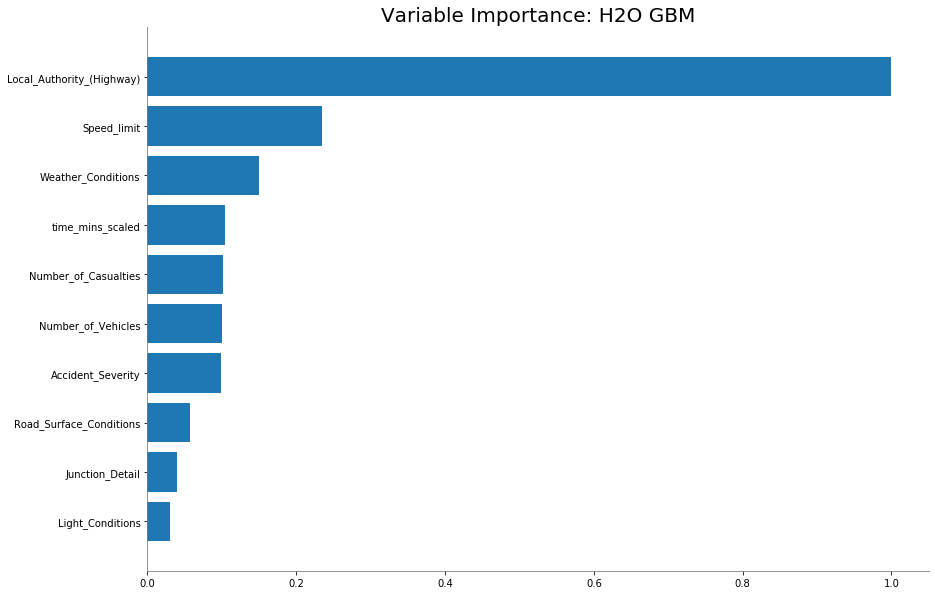

In [333]:
gbm_baseline.varimp_plot()

In [334]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [335]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=100,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1234,balance_classes = True)


In [336]:
rf_v1.train(x=cols, y=y, training_frame=train,
                   validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [337]:
y_pred = rf_v1.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [338]:
from sklearn.metrics import accuracy_score, confusion_matrix
conf_mat = confusion_matrix(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_pred["predict"].as_data_frame().values)

In [339]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score,classification_report
print(classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_pred["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.90      0.64      0.75     17923
           2       0.30      0.69      0.42      3998

    accuracy                           0.65     21921
   macro avg       0.60      0.66      0.58     21921
weighted avg       0.79      0.65      0.69     21921



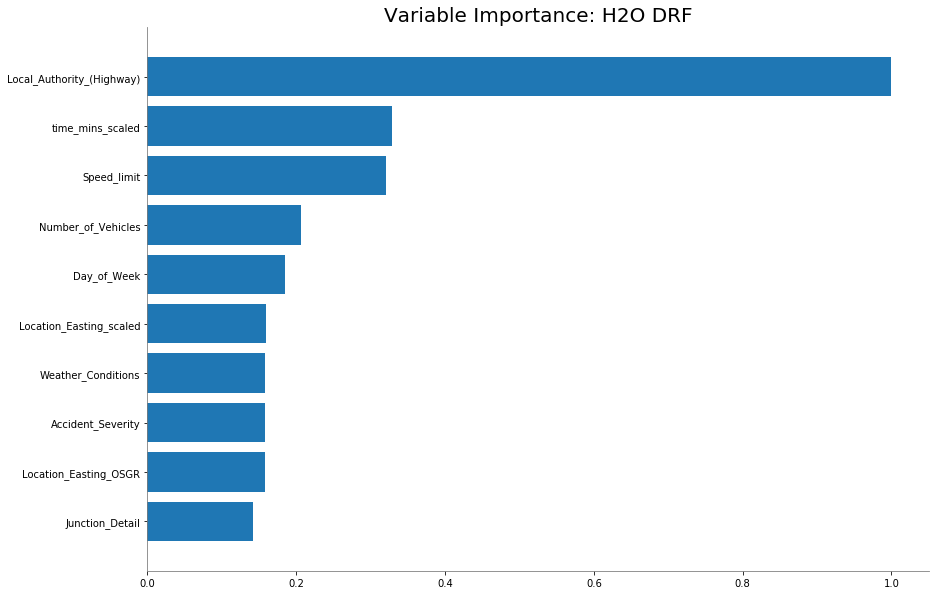

In [340]:
rf_v1.varimp_plot()

In [341]:
rf_v1.auc(valid=True)

0.7328487083959367

In [ ]:

aml = H2OAutoML(max_models=20, seed=1, balance_classes = True)
aml.train(x=cols, y=y, training_frame=train)

In [ ]:
aml.leaderboard

In [ ]:
y_aml_test = aml.leader.predict(test)

In [ ]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_aml_test["predict"].as_data_frame().values))

In [ ]:
aml.leader.coef

In [ ]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [ ]:
metalearner.coef_norm()

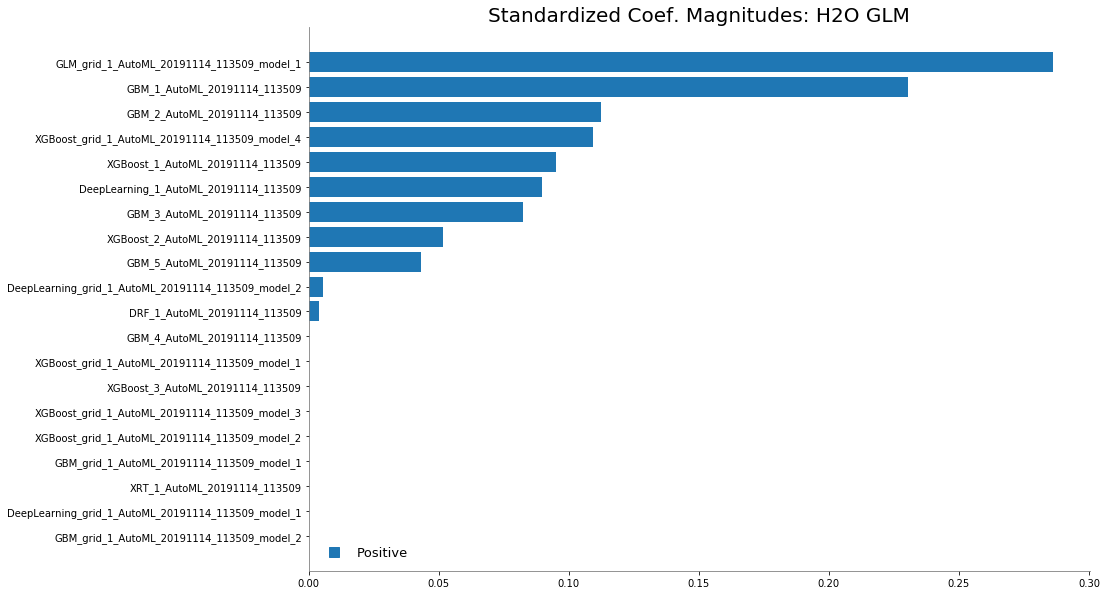

In [342]:
%matplotlib inline
metalearner.std_coef_plot()

In [343]:
param = {
      "ntrees" : 100
    , "max_depth" : 10
    , "learn_rate" : 0.02
    , "sample_rate" : 0.7
    , "col_sample_rate_per_tree" : 0.9
    , "min_rows" : 5
    , "seed": 4241
    , "score_tree_interval": 100
    
}
from h2o.estimators import H2OXGBoostEstimator
model = H2OXGBoostEstimator(**param)

In [344]:
model.train(x=cols, y=y, training_frame=train,validation_frame=valid)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [345]:
y_xgb_test = model.predict(test)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [346]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_xgb_test["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.89      0.74      0.81     17923
           2       0.34      0.60      0.43      3998

    accuracy                           0.71     21921
   macro avg       0.61      0.67      0.62     21921
weighted avg       0.79      0.71      0.74     21921



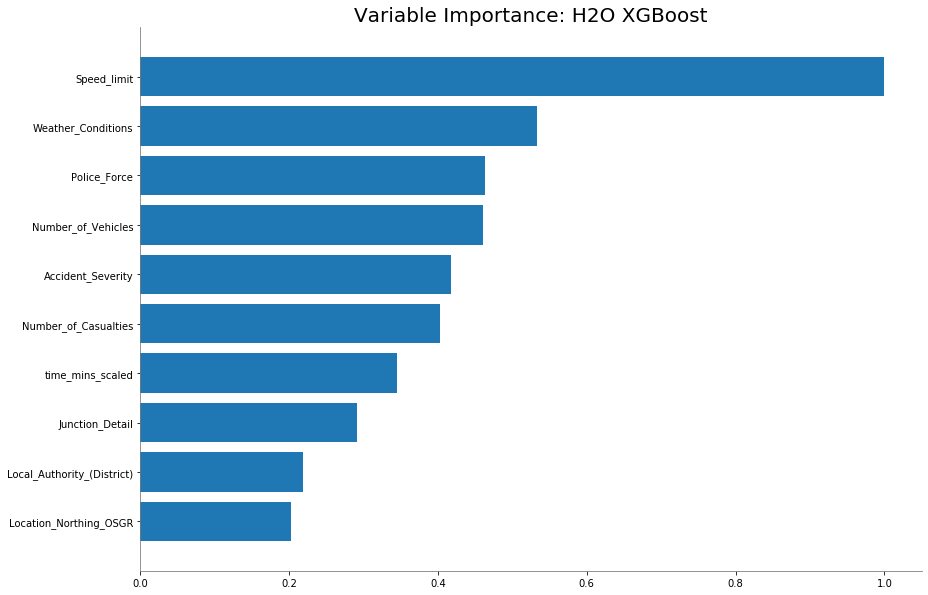

In [347]:
model.varimp_plot()

In [350]:
model.F1(valid=True)

[[0.26230932312247196, 0.44566957140316554]]

In [351]:
model.auc(valid=True)

0.7469247538566661

In [370]:
nfolds = 5

# There are a few ways to assemble a list of models to stack together:
# 1. Train individual models and put them in a list
# 2. Train a grid of models
# 3. Train several grids of models
# Note: All base models must have the same cross-validation folds and
# the cross-validated predicted values must be kept.


# 1. Generate a 2-model ensemble (GBM + RF)

# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=cols, y=y, training_frame=train,validation_frame=valid)


# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=cols, y=y, training_frame=train,validation_frame=valid)


# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial2",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=cols, y=y, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [371]:
y_ens_predict=ensemble.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [372]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_ens_predict["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.89      0.70      0.79     17923
           2       0.32      0.62      0.42      3998

    accuracy                           0.69     21921
   macro avg       0.61      0.66      0.60     21921
weighted avg       0.79      0.69      0.72     21921



In [373]:
ensemble.F1()

[[0.27865902137455306, 0.7025314877166728]]

In [374]:
ensemble.auc(valid=True)

0.7353603706069683

In [375]:
# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.0001, 0.01],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1}

# Train the grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial3")
grid.train(x=cols, y=y, training_frame=train, validation_frame=valid)

# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial3",
                                       base_models=grid.model_ids)
ensemble.train(x=cols, y=y, training_frame=train,validation_frame=valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [376]:
y_ens_predict2=ensemble.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [377]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_ens_predict2["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.89      0.64      0.75     17923
           2       0.29      0.65      0.40      3998

    accuracy                           0.64     21921
   macro avg       0.59      0.64      0.57     21921
weighted avg       0.78      0.64      0.68     21921



In [378]:
ensemble.model_performance(test)



ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.13789767936189604
RMSE: 0.3713457679331973
LogLoss: 0.43784601861232975
Null degrees of freedom: 21920
Residual degrees of freedom: 21916
Null deviance: 20824.448371678744
Residual deviance: 19196.045148001762
AIC: 19206.045148001762
AUC: 0.6991696833184767
pr_auc: 0.34156039427096635
Gini: 0.39833936663695346

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1879602923184778: 


,,1,2,Error,Rate
0,1,11512.0,6411.0,0.3577,(6411.0/17923.0)
1,2,1413.0,2585.0,0.3534,(1413.0/3998.0)
2,Total,12925.0,8996.0,0.3569,(7824.0/21921.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.187960,0.397876,230.0
1,max f2,0.116495,0.572247,311.0
2,max f0point5,0.262536,0.355351,156.0
3,max accuracy,0.823835,0.821632,38.0
4,max precision,0.980575,1.000000,0.0
5,max recall,0.048042,1.000000,395.0
6,max specificity,0.980575,1.000000,0.0
7,max absolute_mcc,0.187960,0.226777,230.0
8,max min_per_class_accuracy,0.188679,0.643698,229.0
9,max mean_per_class_accuracy,0.187960,0.644438,230.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.12 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010036,0.738210,3.763326,3.763326,0.686364,0.882753,0.686364,0.882753,0.037769,0.037769,276.332598,276.332598
1,,2,0.020163,0.335619,2.371023,3.064025,0.432432,0.500988,0.558824,0.691007,0.024012,0.061781,137.102335,206.402466
2,,3,0.049678,0.325491,1.932182,2.391571,0.352396,0.325772,0.436180,0.474012,0.057029,0.118809,93.218247,139.157113
3,,4,0.053009,0.322125,2.403503,2.392321,0.438356,0.322179,0.436317,0.464474,0.008004,0.126813,140.350312,139.232073
4,,5,0.100132,0.285359,1.693199,2.063303,0.308809,0.305177,0.376310,0.389507,0.079790,0.206603,69.319873,106.330341
5,,6,0.150084,0.278353,1.897766,2.008208,0.346119,0.283627,0.366261,0.354267,0.094797,0.301401,89.776601,100.820813
6,,7,0.200036,0.257891,1.572292,1.899353,0.286758,0.268623,0.346408,0.332880,0.078539,0.379940,57.229163,89.935327
7,,8,0.300214,0.226089,1.343283,1.713799,0.244991,0.240538,0.312566,0.302067,0.134567,0.514507,34.328298,71.379935
8,,9,0.400073,0.190844,1.187272,1.582378,0.216537,0.208448,0.288597,0.278699,0.118559,0.633067,18.727180,58.237759
9,,10,0.500023,0.159417,0.943445,1.454661,0.172068,0.174157,0.265304,0.257803,0.094297,0.727364,-5.655509,45.466100


In [379]:
ensemble.auc(valid=True)

0.7035467089712223

In [380]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
dl = H2ODeepLearningEstimator(distribution='auto',
                              model_id='dl',
                              epochs=20,
                              activation='rectifier_with_dropout',
                              hidden_dropout_ratios=[0,0],
                              rate=0.001,
                              loss = "cross_entropy",
                              balance_classes = True,
                              hidden = [400,400],
                              seed=1234)
dl.train(x=cols, y=y, training_frame=train, validation_frame=valid)


deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [381]:
y_dl_predict =dl.predict(test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [382]:
dl.auc(valid=True)

0.7310567269432261

In [ ]:
svmestimator = H2OSupportVectorMachineEstimator(seed = 1)

In [312]:
svmestimator.train(x=cols, y=y, training_frame=train, validation_frame=valid)

████████████████████████| 100%


In [320]:
svmestimator.auc(valid=True)

'NaN'

In [ ]:
y_svm_predict =svmestimator.predict(test)`

In [316]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_svm_predict["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.82      0.99      0.90     18034
           2       0.28      0.02      0.04      3939

    accuracy                           0.82     21973
   macro avg       0.55      0.50      0.47     21973
weighted avg       0.72      0.82      0.74     21973



In [383]:
nvmodel = H2ONaiveBayesEstimator(seed=1234)

In [384]:
nvmodel.train(x=cols, y=y, training_frame=train, validation_frame=valid)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [385]:
y_nvb_predict =nvmodel.predict(test)

naivebayes prediction progress: |█████████████████████████████████████████| 100%


In [386]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_nvb_predict["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.90      0.58      0.70     17923
           2       0.27      0.71      0.39      3998

    accuracy                           0.60     21921
   macro avg       0.59      0.64      0.55     21921
weighted avg       0.79      0.60      0.65     21921



In [387]:
nvmodel.auc(valid=True)

0.6954159299013973